In [1]:
import torch
from torch.utils import data
from PIL import Image
from PIL import ImageChops
from PIL import ImageFilter
import numpy as np
import torchvision.transforms as transforms
import skimage
from skimage import util


class SVHNDataset(data.Dataset):
    def __init__(self, img_path, img_label, transform = None, train = True, test = False):
        self.img_path = img_path
        self.img_label = img_label
        self.test = test
        self.train = train

        if transform is None:
            if self.test or not train:  # 验证集和测试集的图像变换
                self.transform = transforms.Compose([
                    transforms.Resize((60, 120)),
                    transforms.ToTensor(),  # Image->Tensor
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet数据的标准化
                    ])
            else:  # 训练集的图像变换
                self.transform = transforms.Compose([
                    transforms.Resize((64, 128)),
                    transforms.RandomCrop((60, 120)),  # 随机裁剪为60*120
                    transforms.ColorJitter(0.3, 0.3, 0.2),  # 亮度，对比度，饱和度调节
                    transforms.RandomRotation(10),  # 随机旋转-5~5°，旋转角度不可太大。目标检测中bbox框也要跟着旋转
                    transforms.ToTensor(),  # Image->Tensor
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet数据的标准化
                    ])

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')
        if self.train and not self.test:
            img = img.resize((128, 64))
            img = ImageChops.offset(img, np.random.randint(-35, 35), np.random.randint(-10, 10))  # 平移
            if np.random.randint(2):
                # img = np.array(img)
                # img = util.random_noise(img, mode='gaussian')  # 添加噪声
                # img = np.uint8(img*255);
                # img = Image.fromarray(img)
                img = img.filter(ImageFilter.BLUR)  # 图像模糊

        img = self.transform(img)

        lbl = np.array(self.img_label[index], dtype = np.int)
        lbl = list(lbl) + (4-len(lbl)) * [10]  # label长度不足5的部分，赋值为10。

        # getitem函数返回的是每张变换后的图片和对应的label
        return img, torch.from_numpy(np.array(lbl[:4]))  # 获取label的前5个字符，转换为Tensor，返回

    def __len__(self):
        # img_path是个列表，可以通过len返回元素数量
        return len(self.img_path)

In [2]:
import torch
from torch import nn
import torchvision.models as models

class SVHM_Model1(nn.Module):
    def __init__(self):
        super(SVHM_Model1, self).__init__()

        # CNN，提取特征
        model_conv = models.resnet34(pretrained=True)
        model_conv.avgpool = nn.AdaptiveAvgPool2d(1)  # 更改了resnet中的avgpool层
        model_conv = nn.Sequential(*list(model_conv.children())[:-1])  # children获得网络的子层，list封装一下，[:-1]遍历全部元素
        self.cnn = model_conv

        # 全连接网络，分类
        self.fc1 = nn.Linear(512, 11)
        self.fc2 = nn.Linear(512, 11)
        self.fc3 = nn.Linear(512, 11)
        self.fc4 = nn.Linear(512, 11)
        # self.fc5 = nn.Linear(512, 11)

    def forward(self, img):  # img表示输入，用x表示也行
        feat = self.cnn(img)
        feat = feat.view(feat.shape[0], -1)

        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
        # c5 = self.fc5(feat)

        return c1, c2, c3, c4

1.7.0+cu101
True
/usr/local/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 30/30 [00:13<00:00,  2.22it/s]

validation min loss: 580.9738037109375


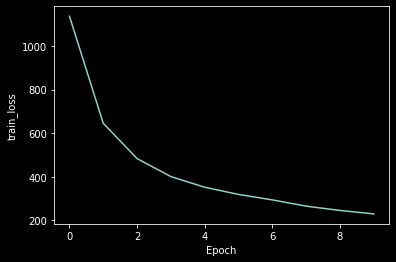

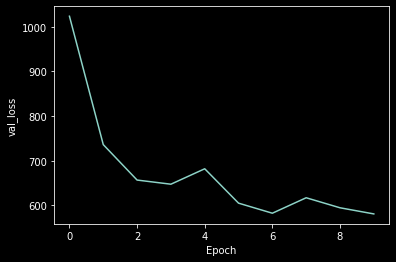

ModuleNotFoundError: No module named 'model.basic_model'; 'model' is not a package

In [3]:
import os, sys, glob, shutil, json
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import cv2
from PIL import Image
import numpy as np

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
# from data.dataset import SVHNDataset
from model.basic_model import SVHM_Model1
import time
import visdom


def train(train_loader, model, criterion, optimizer, epoch):
    model.train()  # 切换为训练模式
    train_loss  = []
    use_cuda = True

    for ii, (input, target) in enumerate(train_loader):  # train_loader中的每个元素是(data, label)
        if use_cuda:
            input = input.cuda()
            target = target.type(torch.cuda.LongTensor)

        c0, c1, c2, c3 = model(input)  # 前向传播
        loss = 2*criterion(c0, target[:,0]) + 1*criterion(c1, target[:,1]) + 2*criterion(c2, target[:,2]) + \
            1*criterion(c3, target[:,3])

        optimizer.zero_grad()
        loss.backward()  # 反向传播
        optimizer.step()

        train_loss.append(loss.item())  # train_loss计算
        vis.line(Y=np.array([loss.item()]), X=np.array([epoch*len(train_loader)+(ii+1)]), win='train_loss', update='append')

    return np.mean(train_loss)


def validate(val_loader, model, criterion, epoch):
    model.eval()  # 切换为验证模式
    val_loss = []
    use_cuda = True

    with torch.no_grad():  # 不计算梯度，也不进行反向传播
        for ii, (input, target) in enumerate(val_loader):
            if use_cuda:
                input = input.cuda()
                target = target.type(torch.cuda.LongTensor)

        c0, c1, c2, c3 = model(input)  # 前向传播
        loss = 2*criterion(c0, target[:,0]) + 1*criterion(c1, target[:,1]) + 2*criterion(c2, target[:,2]) + \
            1*criterion(c3, target[:,3])

        val_loss.append(loss.item())  # val_loss计算（val_acc计算也可以放到这里）
        vis.line(Y=np.array([loss.item()]), X=np.array([epoch*len(val_loader)+(ii+1)]), win='val_loss', update='append')

    return np.mean(val_loss)


def predict(test_loader, model, tta = 10):
    model.eval()  # 切换为验证模式
    test_pred_tta = None
    use_cuda = True

    # TTA次数
    for _ in range(tta):
        test_pred = []
        with torch.no_grad():  # 不计算梯度，也不进行反向传播
            for i, (input, target) in enumerate(test_loader):
                if use_cuda:
                    input = input.cuda()

                c0, c1, c2, c3 = model(input)  # 前向传播
                output = np.concatenate([  # 结果拼接
                    c0.data.cpu().numpy(),
                    c1.data.cpu().numpy(),
                    c2.data.cpu().numpy(),
                    c3.data.cpu().numpy()], axis = 1)

                test_pred.append(output)

        test_pred = np.vstack(test_pred)
        if test_pred_tta is None:
            test_pred_tta = test_pred
        else:
            test_pred_tta += test_pred

    return test_pred_tta


def train_val():
    # 训练集样本
    # train_path = glob.glob('data/mchar/mchar_train/*.png')
    # train_path.sort()
    # train_json = json.load(open('data/mchar/mchar_train.json'))
    # train_label = [train_json[x]['label'] for x in train_json]

    # 训练集样本加权
    train_json = json.load(open('../input/mchar_train.json'))
    train_label = []
    train_path = []
    for x in train_json:
        if len(train_json[x]['label']) in [1,2,4]:
            train_label.append(train_json[x]['label'])
            train_path.append(os.path.join('../input/mchar_train',x))
        if len(train_json[x]['label']) in [3]:
            train_label.append(train_json[x]['label'])
            train_label.append(train_json[x]['label'])
            train_path.append(os.path.join('../input/mchar_train',x))
            train_path.append(os.path.join('../input/mchar_train',x))

    train_data = SVHNDataset(train_path, train_label, train=True)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=40, shuffle=True, num_workers=10, )

    # 验证集样本
    val_path = glob.glob('../input/mchar_val/*.png')
    val_path.sort()
    val_json = json.load(open('../input/mchar_val.json'))
    val_label = [val_json[x]['label'] for x in val_json]

    val_data = SVHNDataset(val_path, val_label, train=False)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=40, shuffle=False, num_workers=10, )

    # 模型，损失函数，优化器
    model = SVHM_Model1()
    model.load_state_dict(torch.load('checkpoints/数据加权-3-0.0001/epoch-14-valacc-0.656-06-11-00_53_28.pth'))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
    best_loss = 1000.0

    use_cuda = True
    if use_cuda:
        model = model.cuda()

    # 创建visdom环境
    global vis
    vis = visdom.Visdom(env='mchar_resnet34_four-4-dataweight-4-0.00001')

    # 开始训练
    for epoch in range(100):
        train_loss = train(train_loader, model, criterion, optimizer, epoch)
        val_loss = validate(val_loader, model, criterion, epoch)

        val_label = [''.join(map(str, x)) for x in val_loader.dataset.img_label]

        val_predict_label = predict(val_loader, model, 1)  # 也可以修改train函数和validata函数，同时返回预测结果和loss
        val_predict_label = np.vstack([  # 字符编码
            val_predict_label[:, :11].argmax(1),
            val_predict_label[:, 11:22].argmax(1),
            val_predict_label[:, 22:33].argmax(1),
            val_predict_label[:, 33:44].argmax(1),
            #val_predict_label[:, 44:55].argmax(1),
        ]).T

        val_label_pred = []
        for x in val_predict_label:
            val_label_pred.append(''.join(map(str, x[x!=10])))

        val_char_acc = np.mean(np.array(val_label_pred) == np.array(val_label))  # val_acc计算

        # log和可视化
        print('Epoch:{0}, Train loss:{1} \t Val loss:{2} \t Val acc:{3}'.format(epoch, train_loss, val_loss, val_char_acc))
        vis.text('Epoch:{0}, Train loss:{1}, Val loss:{2}, Val acc:{3}'.format(epoch, train_loss, val_loss, val_char_acc),win='log_text', append=True)
        vis.line(Y=np.array([val_char_acc]), X=np.array([epoch+1]), win='val_char_acc', update='append')

        # 保存模型
        name = time.strftime('checkpoints/' + 'epoch-{}-valacc-{}-%m-%d-%H_%M_%S.pth'.format(epoch, val_char_acc))
        torch.save(model.state_dict(), name)

        # 保存模型，loss或acc监督
        # if val_loss < best_loss:
        #    best_loss = val_loss
        #    name = time.strftime('checkpoints/' + 'epoch-{}-valacc-{}-%m-%d-%H_%M_%S.pth'.format(epoch,val_char_acc))
        #   torch.save(model.state_dict(), name)

        # 学习率调整
        # if epoch == 5:  # 第5个epoch后，降低学习率
        #     optimizer = torch.optim.Adam(model.parameters(), lr=0.001*0.1, weight_decay=0.0005)
        # if epoch == 12:
        #     optimizer = torch.optim.Adam(model.parameters(), lr=0.0001*0.1, weight_decay=0.0005)


# 测试集预测，生成csv文件
def test_submit(path1, path2, path3):
    test_path = glob.glob('../input/mchar_test_a/*.png')
    test_path.sort()
    test_label = [[1]] * len(test_path)  # test_label其实是没有的，这里把test_label的值设置为1

    test_data = SVHNDataset(test_path, test_label, test=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=40, shuffle=False, num_workers=10,)

    model1 = SVHM_Model1()
    model1 = model1.cuda()
    model1.load_state_dict(torch.load(path1))  # 加载训练好的模型

    test_label = [''.join(map(str, x)) for x in test_loader.dataset.img_label]
    test_predict_label1 = predict(test_loader, model1, 1)

    model2 = SVHM_Model1()
    model2 = model2.cuda()
    model2.load_state_dict(torch.load(path2))
    test_predict_label2 = predict(test_loader, model2, 1)

    model3 = SVHM_Model1()
    model3 = model3.cuda()
    model3.load_state_dict(torch.load(path3))
    test_predict_label3 = predict(test_loader, model3, 1)

    test_predict_label = test_predict_label1 + test_predict_label2 + test_predict_label3  # 集成学习

    test_predict_label = np.vstack([  # 字符编码
        test_predict_label[:, :11].argmax(1),
        test_predict_label[:, 11:22].argmax(1),
        test_predict_label[:, 22:33].argmax(1),
        test_predict_label[:, 33:44].argmax(1),
        # test_predict_label[:, 44:55].argmax(1),
    ]).T
    test_label_pred = []
    for x in test_predict_label:
        test_label_pred.append(''.join(map(str, x[x!=10])))

    import pandas as pd
    df_submit = pd.read_csv('data/mchar/mchar_sample_submit_A.csv')
    df_submit['file_code'] = test_label_pred
    df_submit.to_csv('submit9-3.csv', index = None)

if __name__ =='__main__':
    import fire
    fire.Fire()
    train_val